# Skin Disease Detection using Mobile Application
## Final Year Project 2
Ahmad Daniel Ikhwan Bin Rosli <br>
1201103071

In [34]:
import os
import shutil
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model


In [ ]:
# kaggle.json path
os.environ['PATH'] += os.pathsep + r'C:\Users\ADMIN\AppData\Roaming\Microsoft\Windows\Recent\kaggle.json.lnk'

In [ ]:
# download dataset
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification -p datasets/ham10000_raw --unzip

Dataset URL: https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification


  0%|          | 0.00/2.59G [00:00<?, ?B/s]
  3%|▎         | 70.0M/2.59G [00:00<00:03, 691MB/s]
  6%|▌         | 152M/2.59G [00:00<00:03, 757MB/s] 
  8%|▊         | 225M/2.59G [00:00<00:04, 631MB/s]
 11%|█         | 288M/2.59G [00:00<00:03, 640MB/s]
 13%|█▎        | 351M/2.59G [00:00<00:04, 547MB/s]
 16%|█▌        | 422M/2.59G [00:00<00:03, 597MB/s]
 18%|█▊        | 482M/2.59G [00:00<00:03, 573MB/s]
 20%|██        | 539M/2.59G [00:00<00:03, 577MB/s]
 22%|██▏       | 596M/2.59G [00:01<00:03, 544MB/s]
 25%|██▍       | 659M/2.59G [00:01<00:04, 494MB/s]
 27%|██▋       | 718M/2.59G [00:01<00:03, 525MB/s]
 29%|██▉       | 777M/2.59G [00:01<00:03, 550MB/s]
 31%|███▏      | 831M/2.59G [00:01<00:03, 511MB/s]
 33%|███▎      | 886M/2.59G [00:01<00:03, 528MB/s]
 35%|███▌      | 941M/2.59G [00:01<00:03, 541MB/s]
 37%|███▋      | 994M/2.59G [00:01<00:03, 501MB/s]
 40%|███▉      | 1.02G/2.59G [00:01<00:03, 518MB/s]
 42%|████▏     | 1.08G/2.59G [00:02<00:03, 527MB/s]
 43%|████▎     | 1.12G/2.59G [00:


License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)



In [ ]:
# create path to each directory inside the dataset
raw_path = Path("datasets/ham10000_raw")
images_path = raw_path / "images"
labels_path = raw_path / "GroundTruth.csv"

df = pd.read_csv(labels_path)

In [5]:
df.columns

Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')

In [7]:
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df["label"] = df[["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]].idxmax(axis=1)

In [9]:
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


In [ ]:
# count total for each target class
df["label"] = df["label"].str.lower()

target_classes = ["mel", "nv", "bcc", "bkl", "akiec"]

df = df[df["label"].isin(target_classes)].reset_index(drop=True)

df["label"].value_counts()

label
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
Name: count, dtype: int64

In [ ]:
# create file path for each image
image_dir = Path("datasets/ham10000_raw/images")

df["file_path"] = df["image"].apply(lambda x: image_dir / f"{x}.jpg")

df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label,file_path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,datasets\ham10000_raw\images\ISIC_0024306.jpg
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,datasets\ham10000_raw\images\ISIC_0024307.jpg
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,datasets\ham10000_raw\images\ISIC_0024308.jpg
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,nv,datasets\ham10000_raw\images\ISIC_0024309.jpg
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,mel,datasets\ham10000_raw\images\ISIC_0024310.jpg


In [ ]:
# splitting 80 10 10
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

print("\nTrain Distribution:\n", train_df["label"].value_counts())
print("\nVal Distribution:\n", val_df["label"].value_counts())
print("\nTest Distribution:\n", test_df["label"].value_counts())

Train: (7806, 10)
Val: (976, 10)
Test: (976, 10)

Train Distribution:
 label
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
Name: count, dtype: int64

Val Distribution:
 label
nv       671
mel      111
bkl      110
bcc       52
akiec     32
Name: count, dtype: int64

Test Distribution:
 label
nv       670
mel      112
bkl      110
bcc       51
akiec     33
Name: count, dtype: int64


In [16]:
# copy target classes to new directory
output_dir = Path("datasets/ham10000_prepared")
splits = [("train", train_df), ("val", val_df), ("test", test_df)]

for split_name, df_split in splits:
    for _, row in df_split.iterrows():
        label = row["label"]
        src = row["file_path"]
        dst = output_dir / split_name / label
        dst.mkdir(parents=True, exist_ok=True)
        shutil.copy(src, dst / Path(src).name)

print("All images copied to datasets/ham10000_prepared/")

All images copied to datasets/ham10000_prepared/


In [17]:
# add class weight to handle dataset imbalanced
class_names = sorted(train_df['label'].unique())

label_to_index = {label: idx for idx, label in enumerate(class_names)}
train_df['label_idx'] = train_df['label'].map(label_to_index)

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_idx']),
    y=train_df['label_idx']
)

class_weights_dict = dict(enumerate(weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 5.958778625954198, 1: 3.7985401459854016, 2: 1.7761092150170648, 3: 1.7541573033707865, 4: 0.2910514541387025}


In [19]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# create data generators 
base_dir = Path("datasets/ham10000_prepared")

train_gen = train_datagen.flow_from_directory(
    directory=base_dir / "train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    directory=base_dir / "val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    directory=base_dir / "test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 7806 images belonging to 5 classes.
Found 976 images belonging to 5 classes.
Found 976 images belonging to 5 classes.


In [22]:
# mobilenet
print("Training MobileNet (50 epochs)...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
num_classes = len(train_gen.class_indices)
preds = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)

history_mobilenet = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

model.save("mobilenet_model.h5")
K.clear_session()

Training MobileNet (50 epochs)...
Epoch 1/50
244/244 [==============================] - 107s 431ms/step - loss: 1.4095 - accuracy: 0.5122 - val_loss: 1.0252 - val_accuracy: 0.6250
Epoch 2/50
244/244 [==============================] - 105s 431ms/step - loss: 1.1405 - accuracy: 0.6368 - val_loss: 0.9841 - val_accuracy: 0.6322
Epoch 3/50
244/244 [==============================] - 107s 436ms/step - loss: 1.0457 - accuracy: 0.6548 - val_loss: 0.9068 - val_accuracy: 0.6598
Epoch 4/50
244/244 [==============================] - 101s 412ms/step - loss: 0.9907 - accuracy: 0.6676 - val_loss: 0.8684 - val_accuracy: 0.6721
Epoch 5/50
244/244 [==============================] - 102s 419ms/step - loss: 0.9490 - accuracy: 0.6749 - val_loss: 0.8187 - val_accuracy: 0.6916
Epoch 6/50
244/244 [==============================] - 101s 412ms/step - loss: 0.9137 - accuracy: 0.6861 - val_loss: 0.9049 - val_accuracy: 0.6547
Epoch 7/50
244/244 [==============================] - 100s 411ms/step - loss: 0.8935 - acc

In [23]:
# mobilenetv2
print("Training MobileNetV2 (50 epochs)...")
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
num_classes = len(train_gen.class_indices)
preds = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)

history_mobilenetv2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

model.save("mobilenetv2_model.h5")
K.clear_session()


Training MobileNetV2 (50 epochs)...
Epoch 1/50
244/244 [==============================] - 108s 425ms/step - loss: 1.4319 - accuracy: 0.4755 - val_loss: 1.0498 - val_accuracy: 0.6168
Epoch 2/50
244/244 [==============================] - 103s 423ms/step - loss: 1.2003 - accuracy: 0.5962 - val_loss: 1.0816 - val_accuracy: 0.5656
Epoch 3/50
244/244 [==============================] - 103s 421ms/step - loss: 1.1276 - accuracy: 0.6266 - val_loss: 1.0478 - val_accuracy: 0.5891
Epoch 4/50
244/244 [==============================] - 104s 425ms/step - loss: 1.0748 - accuracy: 0.6448 - val_loss: 1.0679 - val_accuracy: 0.5799
Epoch 5/50
244/244 [==============================] - 103s 422ms/step - loss: 1.0337 - accuracy: 0.6530 - val_loss: 0.9944 - val_accuracy: 0.6148
Epoch 6/50
244/244 [==============================] - 105s 429ms/step - loss: 0.9963 - accuracy: 0.6613 - val_loss: 0.9752 - val_accuracy: 0.6178
Epoch 7/50
244/244 [==============================] - 104s 424ms/step - loss: 0.9847 - a

In [24]:
# mobilenetv3
print("Training MobileNetV3Small (50 epochs)...")
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
num_classes = len(train_gen.class_indices)
preds = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)

history_mobilenetv3 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

model.save("mobilenetv3Large_model.h5")
K.clear_session()


Training MobileNetV3Small (50 epochs)...
Epoch 1/50
244/244 [==============================] - 103s 407ms/step - loss: 1.6167 - accuracy: 0.1376 - val_loss: 1.5497 - val_accuracy: 0.6875
Epoch 2/50
244/244 [==============================] - 98s 403ms/step - loss: 1.6133 - accuracy: 0.1012 - val_loss: 1.6028 - val_accuracy: 0.1127
Epoch 3/50
244/244 [==============================] - 96s 394ms/step - loss: 1.6138 - accuracy: 0.1115 - val_loss: 1.6133 - val_accuracy: 0.0328
Epoch 4/50
244/244 [==============================] - 96s 395ms/step - loss: 1.6121 - accuracy: 0.2191 - val_loss: 1.5335 - val_accuracy: 0.6885
Epoch 5/50
244/244 [==============================] - 96s 392ms/step - loss: 1.6146 - accuracy: 0.1522 - val_loss: 1.6195 - val_accuracy: 0.1137
Epoch 6/50
244/244 [==============================] - 96s 392ms/step - loss: 1.6134 - accuracy: 0.1659 - val_loss: 1.6433 - val_accuracy: 0.0533
Epoch 7/50
244/244 [==============================] - 96s 394ms/step - loss: 1.6143 - ac

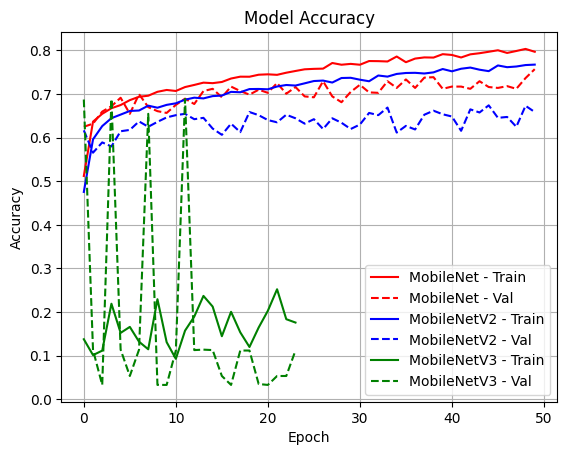

In [39]:
# accuracy
plt.plot(history_mobilenet.history['accuracy'], label='MobileNet - Train', linestyle='-', color='red')
plt.plot(history_mobilenet.history['val_accuracy'], label='MobileNet - Val', linestyle='--', color='red')
plt.plot(history_mobilenetv2.history['accuracy'], label='MobileNetV2 - Train', linestyle='-', color='blue')
plt.plot(history_mobilenetv2.history['val_accuracy'], label='MobileNetV2 - Val', linestyle='--', color='blue')
plt.plot(history_mobilenetv3.history['accuracy'], label='MobileNetV3 - Train', linestyle='-', color='green')
plt.plot(history_mobilenetv3.history['val_accuracy'], label='MobileNetV3 - Val', linestyle='--', color='green')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

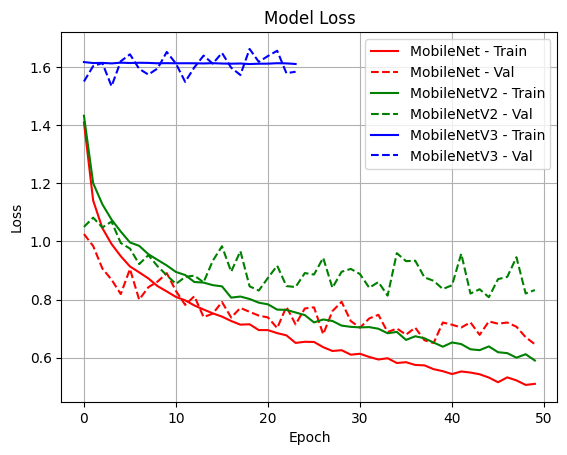

In [38]:
# Loss
plt.plot(history_mobilenet.history['loss'], label='MobileNet - Train', linestyle='-', color='red')
plt.plot(history_mobilenet.history['val_loss'], label='MobileNet - Val', linestyle='--', color='red')
plt.plot(history_mobilenetv2.history['loss'], label='MobileNetV2 - Train', linestyle='-', color='green')
plt.plot(history_mobilenetv2.history['val_loss'], label='MobileNetV2 - Val', linestyle='--', color='green')
plt.plot(history_mobilenetv3.history['loss'], label='MobileNetV3 - Train', linestyle='-', color='blue')
plt.plot(history_mobilenetv3.history['val_loss'], label='MobileNetV3 - Val', linestyle='--', color='blue')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

31/31 [==============================] - 13s 426ms/step


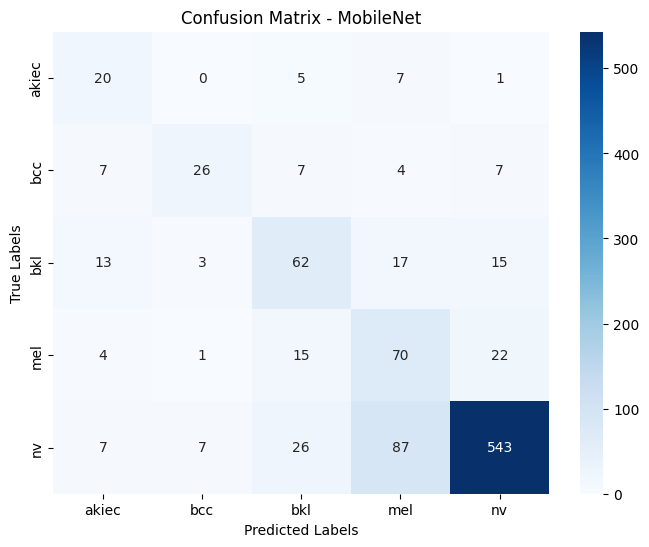

Classification Report:

              precision    recall  f1-score   support

       akiec       0.39      0.61      0.48        33
         bcc       0.70      0.51      0.59        51
         bkl       0.54      0.56      0.55       110
         mel       0.38      0.62      0.47       112
          nv       0.92      0.81      0.86       670

    accuracy                           0.74       976
   macro avg       0.59      0.62      0.59       976
weighted avg       0.79      0.74      0.76       976



In [35]:
#
model = load_model('mobilenet_model.h5')

y_pred = model.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_gen.classes
class_labels = list(test_gen.class_indices.keys())


cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MobileNet')
plt.show()


print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))

31/31 [==============================] - 7s 223ms/step


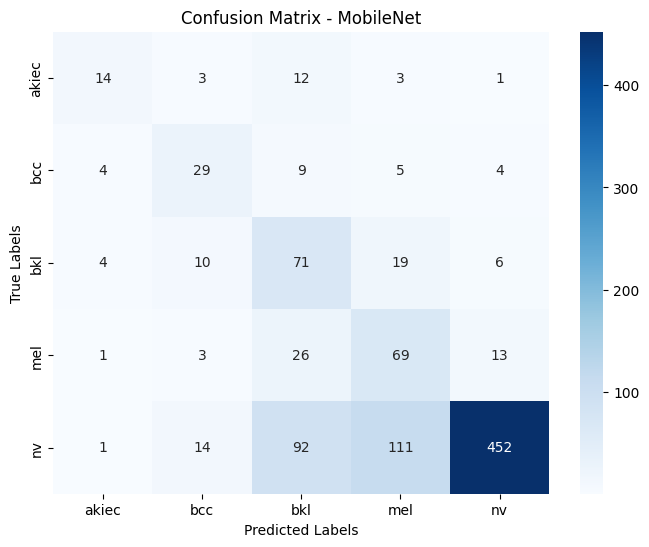

Classification Report:

              precision    recall  f1-score   support

       akiec       0.58      0.42      0.49        33
         bcc       0.49      0.57      0.53        51
         bkl       0.34      0.65      0.44       110
         mel       0.33      0.62      0.43       112
          nv       0.95      0.67      0.79       670

    accuracy                           0.65       976
   macro avg       0.54      0.59      0.54       976
weighted avg       0.77      0.65      0.69       976



In [36]:
#
model = load_model('mobilenetv2_model.h5')

y_pred = model.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_gen.classes
class_labels = list(test_gen.class_indices.keys())


cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MobileNet')
plt.show()


print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))

31/31 [==============================] - 6s 157ms/step


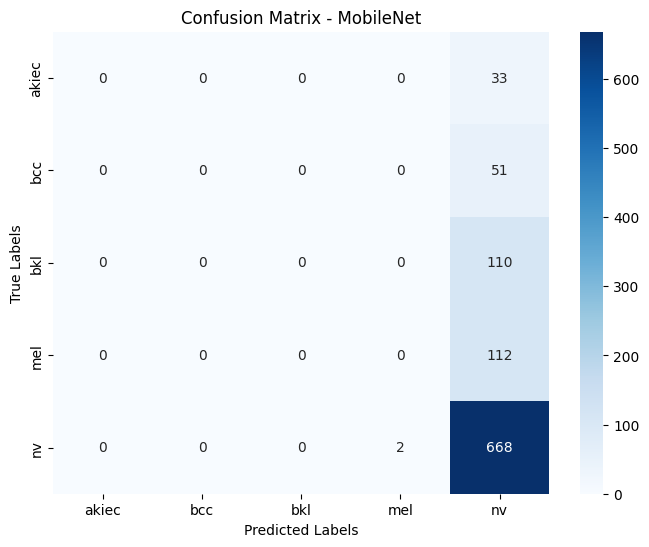

Classification Report:

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.00      0.00      0.00        51
         bkl       0.00      0.00      0.00       110
         mel       0.00      0.00      0.00       112
          nv       0.69      1.00      0.81       670

    accuracy                           0.68       976
   macro avg       0.14      0.20      0.16       976
weighted avg       0.47      0.68      0.56       976



c:\Users\ADMIN\anaconda3\envs\fyp-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\anaconda3\envs\fyp-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ADMIN\anaconda3\envs\fyp-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
#
model = load_model('mobilenetv3Large_model.h5')

y_pred = model.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_gen.classes
class_labels = list(test_gen.class_indices.keys())


cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MobileNet')
plt.show()


print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))

In [40]:
# fine tune mobilenet
print("Fine-tuning MobileNet...")

mobilenet_model = load_model("mobilenet_model.h5")

for layer in mobilenet_model.layers:
    layer.trainable = True

mobilenet_model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)

history_mobilenet_ft = mobilenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

mobilenet_model.save("mobilenet_finetuned.h5")
K.clear_session()


Fine-tuning MobileNet...
Epoch 1/50
244/244 [==============================] - 139s 546ms/step - loss: 1.9009 - accuracy: 0.5949 - val_loss: 1.0078 - val_accuracy: 0.6814
Epoch 2/50
244/244 [==============================] - 130s 532ms/step - loss: 1.2185 - accuracy: 0.6153 - val_loss: 0.9901 - val_accuracy: 0.6598
Epoch 3/50
244/244 [==============================] - 130s 531ms/step - loss: 1.0350 - accuracy: 0.6571 - val_loss: 0.9296 - val_accuracy: 0.6803
Epoch 4/50
244/244 [==============================] - 130s 531ms/step - loss: 0.9581 - accuracy: 0.6687 - val_loss: 0.9078 - val_accuracy: 0.6844
Epoch 5/50
244/244 [==============================] - 130s 531ms/step - loss: 0.8600 - accuracy: 0.6847 - val_loss: 0.9435 - val_accuracy: 0.6680
Epoch 6/50
244/244 [==============================] - 130s 531ms/step - loss: 0.8012 - accuracy: 0.6984 - val_loss: 0.8845 - val_accuracy: 0.6834
Epoch 7/50
244/244 [==============================] - 130s 532ms/step - loss: 0.7639 - accuracy: 0.

In [41]:
#fine tune mobilenetv2
print("Fine-tuning MobileNetV2...")

mobilenetv2_model = load_model("mobilenetv2_model.h5")

for layer in mobilenetv2_model.layers:
    layer.trainable = True

mobilenetv2_model.compile(
    optimizer=Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)

history_mobilenetv2_ft = mobilenetv2_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

mobilenetv2_model.save("mobilenetv2_finetuned.h5")
K.clear_session()


Fine-tuning MobileNetV2...
Epoch 1/50
244/244 [==============================] - 171s 671ms/step - loss: 1.6561 - accuracy: 0.5199 - val_loss: 0.7456 - val_accuracy: 0.7070
Epoch 2/50
244/244 [==============================] - 160s 652ms/step - loss: 1.2035 - accuracy: 0.5760 - val_loss: 0.7884 - val_accuracy: 0.7346
Epoch 3/50
244/244 [==============================] - 159s 652ms/step - loss: 1.0724 - accuracy: 0.6134 - val_loss: 0.8906 - val_accuracy: 0.7223
Epoch 4/50
244/244 [==============================] - 159s 651ms/step - loss: 0.9675 - accuracy: 0.6400 - val_loss: 0.9289 - val_accuracy: 0.7213
Epoch 5/50
244/244 [==============================] - 159s 651ms/step - loss: 0.8826 - accuracy: 0.6674 - val_loss: 0.8958 - val_accuracy: 0.7275
Epoch 6/50
244/244 [==============================] - 159s 651ms/step - loss: 0.8351 - accuracy: 0.6761 - val_loss: 0.8092 - val_accuracy: 0.7346
Epoch 7/50
244/244 [==============================] - 159s 651ms/step - loss: 0.7964 - accuracy: 

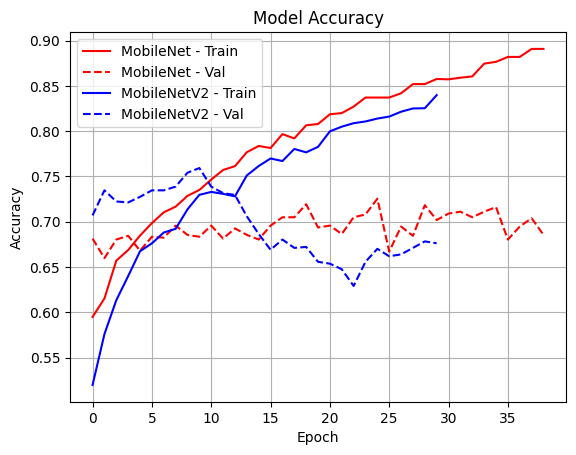

In [42]:
# accuracy
plt.plot(history_mobilenet_ft.history['accuracy'], label='MobileNet - Train', linestyle='-', color='red')
plt.plot(history_mobilenet_ft.history['val_accuracy'], label='MobileNet - Val', linestyle='--', color='red')
plt.plot(history_mobilenetv2_ft.history['accuracy'], label='MobileNetV2 - Train', linestyle='-', color='blue')
plt.plot(history_mobilenetv2_ft.history['val_accuracy'], label='MobileNetV2 - Val', linestyle='--', color='blue')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

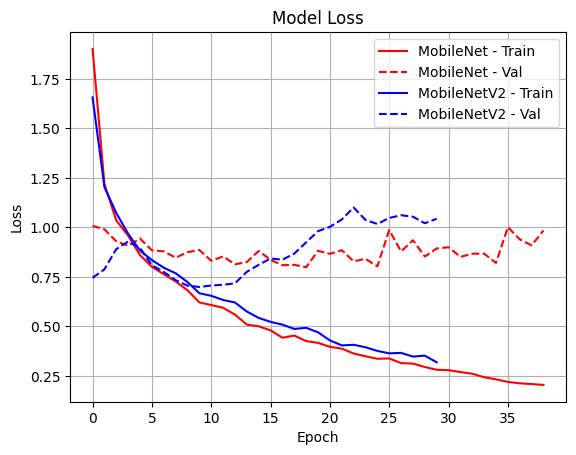

In [43]:
# loss
plt.plot(history_mobilenet_ft.history['loss'], label='MobileNet - Train', linestyle='-', color='red')
plt.plot(history_mobilenet_ft.history['val_loss'], label='MobileNet - Val', linestyle='--', color='red')
plt.plot(history_mobilenetv2_ft.history['loss'], label='MobileNetV2 - Train', linestyle='-', color='blue')
plt.plot(history_mobilenetv2_ft.history['val_loss'], label='MobileNetV2 - Val', linestyle='--', color='blue')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

31/31 [==============================] - 9s 261ms/step


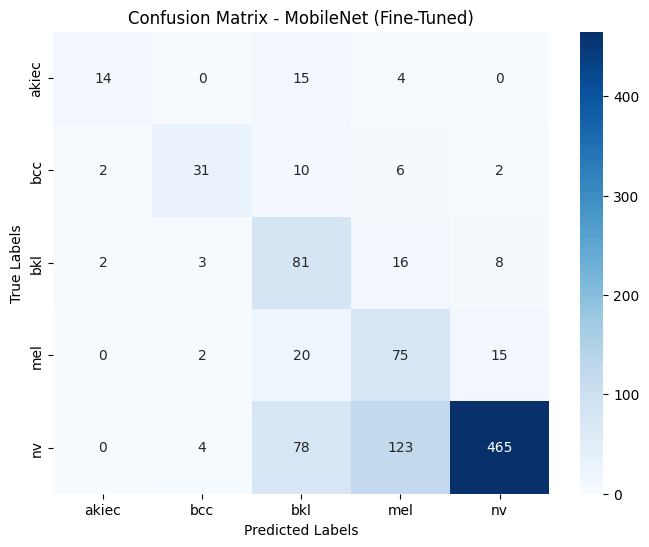

Classification Report:

              precision    recall  f1-score   support

       akiec       0.78      0.42      0.55        33
         bcc       0.78      0.61      0.68        51
         bkl       0.40      0.74      0.52       110
         mel       0.33      0.67      0.45       112
          nv       0.95      0.69      0.80       670

    accuracy                           0.68       976
   macro avg       0.65      0.63      0.60       976
weighted avg       0.80      0.68      0.71       976



In [44]:
#
model = load_model('mobilenet_finetuned.h5')
y_pred = model.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MobileNet (Fine-Tuned)')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))

31/31 [==============================] - 8s 223ms/step


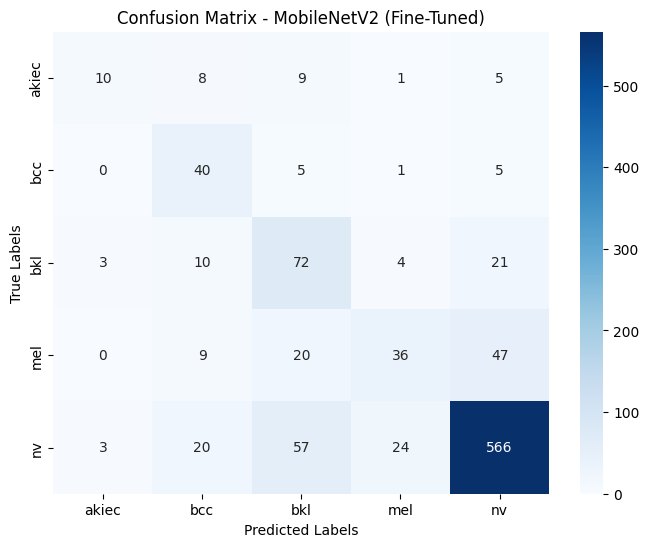

Classification Report:

              precision    recall  f1-score   support

       akiec       0.62      0.30      0.41        33
         bcc       0.46      0.78      0.58        51
         bkl       0.44      0.65      0.53       110
         mel       0.55      0.32      0.40       112
          nv       0.88      0.84      0.86       670

    accuracy                           0.74       976
   macro avg       0.59      0.58      0.56       976
weighted avg       0.76      0.74      0.74       976



In [45]:
#
model = load_model('mobilenetv2_finetuned.h5')
y_pred = model.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - MobileNetV2 (Fine-Tuned)')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))
